In [41]:
import numpy as np
import pandas as pd
import dill as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
import itertools
%matplotlib inline

# Raw Data - will not use

In [2]:
data1 = pd.read_csv('genres.csv', header=None, encoding = "ISO-8859-1")
data2 = pd.read_csv('genres2.csv', header=None, encoding = "ISO-8859-1")
data3 = pd.read_csv('genres3.csv', header=None, encoding = "ISO-8859-1")

data = pd.concat([data1, data2, data3])

In [34]:
data = data.reset_index(drop=True)
data.groupby(1)[0].nunique()

# ACTUAL Data

## Read in train and test txt files

In [120]:
train_genres = open("train_genres.txt", encoding="utf-8").read().split('\n')
train_plots = open("train_plots.txt", encoding="utf-8").read().split('\n')

In [121]:
train_data = pd.DataFrame({"genres": train_genres, "plots": train_plots})

In [122]:
len(train_data)

204682

In [123]:
train_data.loc[4]["genres"].split(" ")

['Adventure', 'Animation', 'Comedy', '']

In [124]:
test_genres = open("test_genres.txt", encoding="utf-8").read().split('\n')
test_plots = open("test_plots.txt", encoding="utf-8").read().split('\n')

In [125]:
test_data = pd.DataFrame({"genres": test_genres, "plots": test_plots})

In [126]:
len(test_data)

51171

In [127]:
#Concat dataframes
full_data = pd.concat([train_data, test_data], ignore_index= True)

# BRIEF EDA

In [128]:
#Convert genres to list for easier analysis
def list_genres(row):
    return row["genres"].split(" ")[:-1]

In [129]:
full_data["list_genres"] = full_data.apply(lambda row: list_genres(row), axis = 1)

In [130]:
count_dict = defaultdict(int)

In [131]:
#Count num of movies per genre
def dict_count(row):
    global count_dict
    for genre in row["list_genres"]:
        count_dict[genre] += 1

In [132]:
#RUN ONLY ONCE!!!
count_val_series = full_data.apply(lambda row: dict_count(row), axis = 1)

27.88% of the movies are Comedy
45.84% of the movies are Drama
2.37% of the movies are Western
7.00% of the movies are Adventure
6.21% of the movies are Animation
9.71% of the movies are Action
11.18% of the movies are Thriller
8.08% of the movies are Family
11.01% of the movies are Romance
5.89% of the movies are Fantasy
7.77% of the movies are Horror
4.77% of the movies are History
4.95% of the movies are Music
5.60% of the movies are Sci-Fi
2.85% of the movies are War
7.27% of the movies are Crime
2.23% of the movies are Musical
5.18% of the movies are Biography
5.40% of the movies are Mystery
2.37% of the movies are Sport


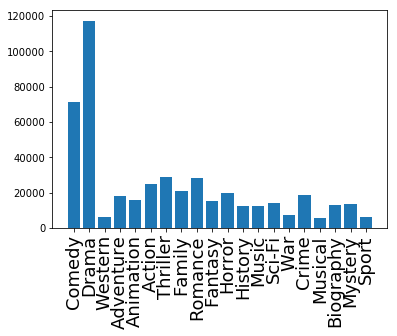

In [133]:
#Count num of movies per genre
for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(full_data), key))



fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict.keys())), list(count_dict.values()))
ax.set_xticks(range(len(count_dict.keys())))
ax.set_xticklabels(list(count_dict.keys()), rotation='vertical', fontsize=18)



Avg num of genres: 1.835858872086706
Median num of genres: 1.0
Max number of genres: 11
Min number of genres: 1


(array([  1.29306000e+05,   6.44310000e+04,   4.38940000e+04,
          1.29500000e+04,   3.96000000e+03,   1.01100000e+03,
          2.36000000e+02,   5.20000000e+01,   6.00000000e+00,
          7.00000000e+00]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.]),
 <a list of 10 Patch objects>)

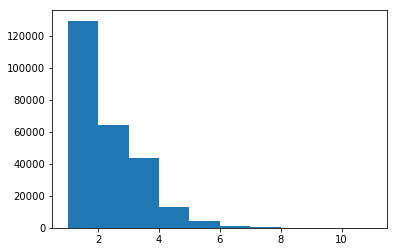

In [134]:
#Number of genres per movie
genre_labels = full_data["list_genres"].str.len()
print("Avg num of genres:", np.mean(genre_labels))
print("Median num of genres:", np.median(genre_labels))
print("Max number of genres:", np.max(genre_labels))
print("Min number of genres:", np.min(genre_labels))


plt.hist(genre_labels)

# Preprocessing

In [149]:
#Explore removing stopwords
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')
stop = [word.replace("'","") for word in stop]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharadvaradarajan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [229]:
def tokenize(plots):
    
    def re_sub(pattern, replace):
        return re.sub(pattern, replace, plots)
    
    plots = plots.lower() #lowercase
    plots = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>") #generic tag for numbers
    plots = re_sub(r"([!?.]){2,}", r"\1") #Convert multiple punctuations to a single punctuation
    plots = plots.replace('-',' ') #separating hyphenated words
    plots = re_sub(r'(?<!\w)([a-zA-Z])\.', r'\1') #remove periods from abbreviations
    plots = re_sub('[^\w\s\.\<>\?\!]','') #remove punctuation besides sentence completers and <> for generic number
    plots = plots.lower().split()
    output = list(itertools.chain(*[re.split(r'([^\w<>])', x) for x in plots if x not in stop])) #split sentence enders and remove stopwords
    return [item for item in output if item != ''] 


In [230]:
#Test Tokenizer
print(tokenize("Hello, MYself dear $$20-30 hello? 2,00.0 A.J.A what??"))
print("\n")
print(full_data["plots"][0])
print("\n")
print(tokenize(full_data["plots"][0]))

['hello', 'dear', '<number><number>', 'hello', '?', '<number>', 'aja', 'what', '?']


A stranded theatrical troupe manages to get back home through the leading man finding a glass eye. An idea strikes him. He buys a bag of walnuts and the comedian later also buys a bag. The leading man then goes to the fruit dealer, offering him $100 for the return of his glass eye, and saying he will return later in view of his finding it. The comedian enters, stating he found a glass eye in the bag of walnuts he bought. The fruit seller pays him $50 for it. He is still waiting for the $100 and the troupe is back in New York. 


['stranded', 'theatrical', 'troupe', 'manages', 'get', 'back', 'home', 'leading', 'man', 'finding', 'glass', 'eye', '.', 'idea', 'strikes', 'him', '.', 'buys', 'bag', 'walnuts', 'comedian', 'later', 'also', 'buys', 'bag', '.', 'leading', 'man', 'goes', 'fruit', 'dealer', 'offering', '<number>', 'return', 'glass', 'eye', 'saying', 'return', 'later', 'view', 'finding', 'it', '.'

In [231]:
full_data["plots_processed"] = full_data["plots"].apply(lambda row: tokenize(row))

In [232]:
full_data["plots_processed"].head()

0    [stranded, theatrical, troupe, manages, get, b...
1    [waiting, bus, stop, woman, intends, marry, ja...
2    [dissatisfied, ranch, hand, becomes, bounty, h...
3    [policeman, lasse, rehabilitates, young, priso...
4    [patricia, isobelle, osullivan, arrives, st, ....
Name: plots_processed, dtype: object

In [217]:
x = pkl.load(open("vocab060000.pkl", "rb"))

# Load Word Embeddings

In [228]:
def loadEmbed(file):
    print("Loading Embeddings")
    f = open(file, 'r', encoding='utf-8')
    model = {}
    status_every = 100000
    for i, line in enumerate(f):
        if i%status_every == 0:
            print('Processing line {:,}'.format(i))
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",'{:,}'.format(len(model))," words loaded!")
    return model

In [ ]:
#TOO LARGE TO PUSH TO GIT, DOWNLOAD SEPARATLEY FROM https://github.com/stanfordnlp/GloVe
glove_dir = './glove.6B/'
glove_filename = 'glove.6B.50d.txt'
glove_fullpath = glove_dir + glove_filename
glove_dd = loadEmbed(glove_fullpath)

**Can also use assignment 2 code for glove embeddings since we are using the same embeddings**